In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor,plot_importance

import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Load Data

In [3]:
df = pd.read_csv('data/data_be.csv')
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
df.drop('date', axis=1, inplace=True)
df

,price,ActualLoad,ForecastLoad,weekday,season,period
date,,,,,,
2020-01-01 00:00:00,38.60,8700.50,8544.00,Wednesday,winter,night
2020-01-01 01:00:00,36.55,8320.25,8185.75,Wednesday,winter,night
2020-01-01 02:00:00,32.32,8000.75,7896.75,Wednesday,winter,night
2020-01-01 03:00:00,30.85,7795.50,7720.50,Wednesday,winter,night
2020-01-01 04:00:00,30.14,7784.00,7660.25,Wednesday,winter,night
...,...,...,...,...,...,...
2022-12-31 19:00:00,-32.27,8171.75,9171.00,Saturday,winter,evening
2022-12-31 20:00:00,6.20,7846.25,8592.75,Saturday,winter,evening
2022-12-31 21:00:00,35.96,7794.00,8693.50,Saturday,winter,evening


# Data preprocessing

In [4]:
# data preprocessing - prices and power load of the previous 4 weeks at the same time of the day
for i in range(4):
    df['price_d{}'.format(i+1)] = df['price'].shift((i+1)*168)

#df['price_d{}'.format(7)] = df['price'].shift(7*24)

for i in range(4):
    df['ActualLoad_d{}'.format(i+1)] = df['ActualLoad'].shift((i+1)*168)


df.dropna(inplace=True)

In [5]:
# one-hot encoding
data = df.drop(['ActualLoad','ForecastLoad'],axis=1)
data = pd.get_dummies(data, columns = ['weekday', 'season','period'])
data

,price,price_d1,price_d2,price_d3,price_d4,ActualLoad_d1,ActualLoad_d2,ActualLoad_d3,ActualLoad_d4,weekday_Friday,...,weekday_Tuesday,weekday_Wednesday,season_fall,season_spring,season_summer,season_winter,period_afternoon,period_evening,period_morning,period_night
date,,,,,,,,,,,,,,,,,,,,,
2020-01-29 00:00:00,28.66,38.54,19.30,27.28,38.60,10482.25,9053.75,9187.25,8700.50,0,...,0,1,0,0,0,1,0,0,0,1
2020-01-29 01:00:00,23.19,35.66,15.96,24.60,36.55,10135.75,8691.00,8884.50,8320.25,0,...,0,1,0,0,0,1,0,0,0,1
2020-01-29 02:00:00,20.83,34.85,11.06,20.86,32.32,10021.50,8611.00,8569.50,8000.75,0,...,0,1,0,0,0,1,0,0,0,1
2020-01-29 03:00:00,21.49,34.00,10.52,19.36,30.85,9985.50,8778.00,8591.50,7795.50,0,...,0,1,0,0,0,1,0,0,0,1
2020-01-29 04:00:00,26.37,34.94,19.15,25.00,30.14,10371.75,9069.00,9152.75,7784.00,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,-32.27,350.00,341.98,246.47,257.66,8153.75,10566.75,10093.25,9813.25,0,...,0,0,0,0,0,1,0,1,0,0
2022-12-31 20:00:00,6.20,338.04,300.33,224.34,229.47,7894.00,10177.75,9756.75,9428.25,0,...,0,0,0,0,0,1,0,1,0,0
2022-12-31 21:00:00,35.96,315.27,297.49,230.00,217.80,7936.75,10158.75,9753.50,9281.50,0,...,0,0,0,0,0,1,0,1,0,0


In [6]:
# data preprocessing - scaling
X = data.drop('price',axis=1)
scaler_X = StandardScaler()
scaler_X.fit(X.iloc[:, 0:8])
X_scaled = X.copy()
X_scaled.iloc[:, 0:8] = scaler_X.transform(X.iloc[:, 0:8])

y = data['price']
scaler_y = StandardScaler()
scaler_y.fit(y.values.reshape(-1,1))
y_scaled = scaler_y.transform(y.values.reshape(-1,1))

# Machine Learning Models

In [7]:
# hyperparameters tuning - random search
# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(5, 20),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.1),
    'n_estimators':stats.randint(200, 1500)
}

# Create the XGBoost model object
xgb_model = XGBRegressor()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_root_mean_squared_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_scaled, y)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.013219208915262728, 'max_depth': 18, 'n_estimators': 1189, 'subsample': 0.5856688061683479}
Best score:  -27.600013251336076


In [7]:
# Model training
preds = []
tests = []
y_indices = []
mymae = 0
myrmse = 0
mymase = 0
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #y_train, y_test = y_scaled[train_index], y_scaled[test_index]
    
    #regressor = SVR(kernel= 'rbf')
    #regressor = RandomForestRegressor(n_estimators = 1000, max_features = 'sqrt', max_depth = 20, random_state = 18)
    #regressor = Lasso()
    #regressor = LinearRegression()
    #regressor = Ridge()
    regressor = XGBRegressor(n_estimators=1200, max_depth=18, learning_rate=0.02, subsample=0.6)
    regressor.fit(X_train,y_train)

    y_pred = regressor.predict(X_test)
    #mse = mean_squared_error( scaler_y.inverse_transform(y_test) , scaler_y.inverse_transform(y_pred.reshape(-1,1)))
    mse = mean_squared_error( y_test , y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test-y_pred))
    mae_naive = np.mean(np.abs(y_test-X['price_d1'].iloc[test_index]))

    mymase = mymase + mae/mae_naive
    mymae = mymae + mae
    myrmse = rmse + myrmse

    preds.append(y_pred)
    tests.append(y_test)
    y_indices.append(y_test.index)

    print(f"Test score: {mae}")

print('*******************************')
print(f'ave mae:{mymae/5}')
print(f'ave rmse:{myrmse/5}')
print(f'ave mase:{mymase/5}')

Test score: 10.001934528109597
Test score: 10.28159046461272
Test score: 10.17463737015646
Test score: 10.068654109377196
Test score: 9.732416735872645
*******************************
ave mae:10.051846641625724
ave rmse:18.25035162446808
ave mase:0.4335875123638572


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

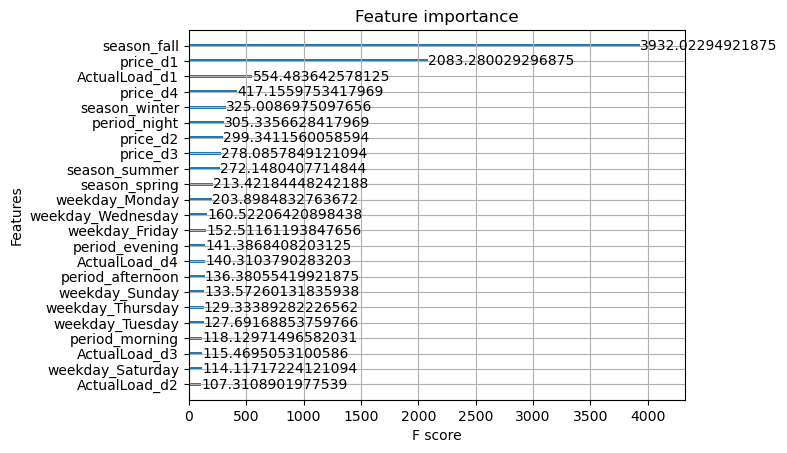

In [8]:
plot_importance(regressor,importance_type='gain')

Text(0.5, 0, 'Random Forest Feature Importance')

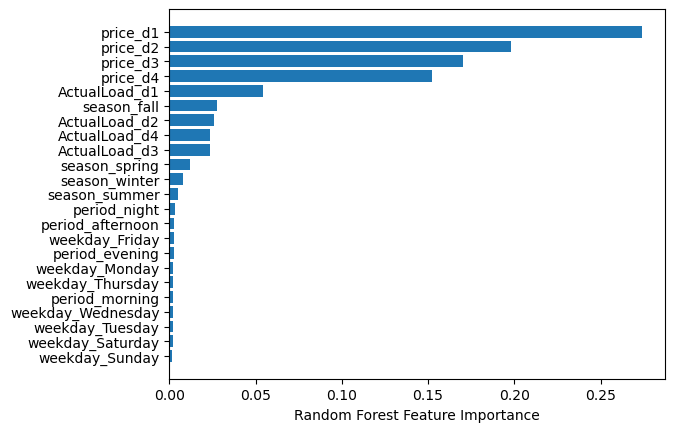

In [20]:
# random forest
sorted_idx = regressor.feature_importances_.argsort()
plt.barh(regressor.feature_names_in_[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

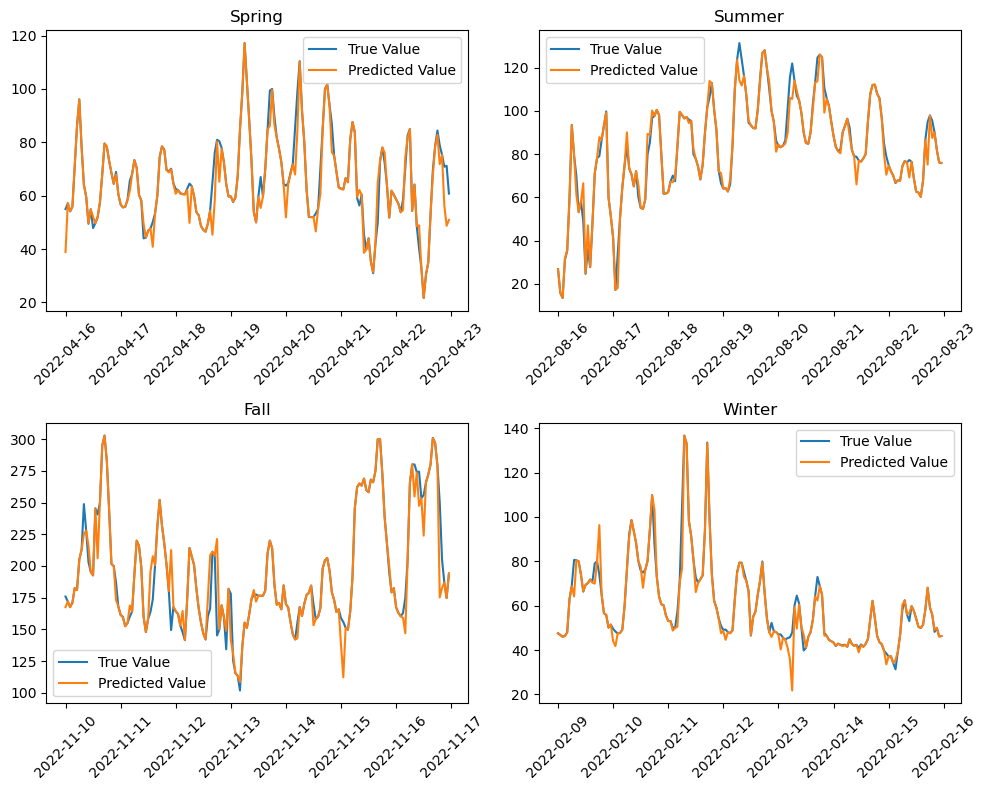

In [60]:

## Prediction expamples
st_spring = data.index.get_loc('2022-04-16 00:00:00')
st_summer = data.index.get_loc('2022-08-16 00:00:00')
st_fall = data.index.get_loc('2022-11-10 00:00:00')
st_winter = data.index.get_loc('2022-02-09 00:00:00')

p = 168
spring_y = data.iloc[st_spring:st_spring+p,0]
spring_X = X_scaled[st_spring:st_spring+p]
spring_pred = regressor.predict(spring_X)
summer_y = data.iloc[st_summer:st_summer+p,0]
summer_X = X_scaled[st_summer:st_summer+p]
summer_pred = regressor.predict(summer_X)
fall_y = data.iloc[st_fall:st_fall+p,0]
fall_X = X_scaled[st_fall:st_fall+p]
fall_pred = regressor.predict(fall_X)
winter_y = data.iloc[st_winter:st_winter+p,0]
winter_X = X_scaled[st_winter:st_winter+p]
winter_pred = regressor.predict(winter_X)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot data on each subplot
axs[0, 0].plot(spring_y, label='True Value')
axs[0, 0].plot(spring_y.index,spring_pred, label='Predicted Value')
axs[0, 0].set_title('Spring')
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=45)

axs[0, 1].plot(summer_y, label='True Value')
axs[0, 1].plot(summer_y.index,summer_pred, label='Predicted Value')
axs[0, 1].set_title('Summer')
axs[0, 1].legend()
axs[0, 1].tick_params(axis='x', rotation=45)

axs[1, 0].plot(fall_y, label='True Value')
axs[1, 0].plot(fall_y.index,fall_pred, label='Predicted Value')
axs[1, 0].set_title('Fall')
axs[1, 0].legend()
axs[1, 0].tick_params(axis='x', rotation=45)

axs[1, 1].plot(winter_y, label='True Value')
axs[1, 1].plot(winter_y.index,winter_pred, label='Predicted Value')
axs[1, 1].set_title('Winter')
axs[1, 1].legend()
axs[1, 1].tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [15]:
#  Performance details in different seasons, weekdays and periods of the day
test_output = pd.DataFrame({'true':y_test, 'pred':y_pred,'season':df.loc[y_test.index,'season'],'weekday':df.loc[y_test.index,'weekday'],'period':df.loc[y_test.index,'period'],'priced1':df.loc[y_test.index,'price_d1']})
test_output['diff'] = test_output['true'] - test_output['pred']
test_output['naive'] = np.abs( test_output['true'] - test_output['priced1'])

# season
avePred_season = test_output.groupby('season')['pred'].mean()
aveTrue_season = test_output.groupby('season')['true'].mean()
varPred_season = test_output.groupby('season')['pred'].var()
varTrue_season = test_output.groupby('season')['true'].var()
mae_season = test_output.groupby('season')['diff'].agg(lambda x: x.abs().mean())

result_season = pd.DataFrame({'PredMean': avePred_season, 'TrueMean':aveTrue_season, 'PredVar': varPred_season,'TrueVar':varTrue_season,'MAE':mae_season})
print(result_season)

#weekday
avePred_weekday = test_output.groupby('weekday')['pred'].mean()
aveTrue_weekday = test_output.groupby('weekday')['true'].mean()
varPred_weekday = test_output.groupby('weekday')['pred'].var()
varTrue_weekday = test_output.groupby('weekday')['true'].var()
mae_weekday = test_output.groupby('weekday')['diff'].agg(lambda x: x.abs().mean())

result_weekday = pd.DataFrame({'PredMean': avePred_weekday, 'TrueMean':aveTrue_weekday, 'PredVar': varPred_weekday,'TrueVar':varTrue_weekday,'MAE':mae_weekday})

print(result_weekday)

# period of a day
avePred_period = test_output.groupby('period')['pred'].mean()
aveTrue_period = test_output.groupby('period')['true'].mean()
varPred_period = test_output.groupby('period')['pred'].var()
varTrue_period = test_output.groupby('period')['true'].var()
mae_period = test_output.groupby('period')['diff'].agg(lambda x: x.abs().mean())

result_period = pd.DataFrame({'PredMean': avePred_period, 'TrueMean':aveTrue_period, 'PredVar': varPred_period,'TrueVar':varTrue_period,'MAE':mae_period})
print(result_period)

          PredMean    TrueMean      PredVar       TrueVar        MAE
season                                                              
fall    123.875648  126.255030  5486.135742   6278.295746  14.947784
spring   41.482582   41.396563   585.570984    763.324950   7.449119
summer   61.414410   61.465892   840.118042   1009.905910   7.124755
winter   99.164413  100.322625  9823.204102  11006.789436  13.798821
            PredMean   TrueMean      PredVar      TrueVar        MAE
weekday                                                             
Friday     86.795891  87.531084  5622.881348  6259.109197  10.716466
Monday     73.467865  74.486291  4154.251953  4884.528192  11.202376
Saturday   75.888329  77.853238  4226.039551  5216.186888  11.475632
Sunday     64.322647  64.468498  3630.461426  3982.437542  10.514162
Thursday   88.395561  88.844495  5584.995605  6194.238102  10.496338
Tuesday    88.217613  88.327386  5777.948730  6175.209812  10.398520
Wednesday  88.333473  89.805155  5

# Feedforward Neural Networks

In [5]:
# Scaling
X = data.drop('price',axis=1)
scaler_X = MinMaxScaler()
scaler_X.fit(X.iloc[:, 0:8])
X_scaled = X.copy()
X_scaled.iloc[:, 0:8] = scaler_X.transform(X.iloc[:, 0:8])
y = data['price']

scaler_y = MinMaxScaler()
scaler_y.fit(y.values.reshape(-1,1))
y_scaled = scaler_y.transform(y.values.reshape(-1,1))

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mymae = 0
myrmse = 0
mymase = 0
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = Sequential()
    model.add(Dense(64, input_dim=X_scaled.shape[1], activation='relu',activity_regularizer=l2(0.01)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Compile the model with appropriate loss function and optimizer
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping = EarlyStopping(monitor='loss', patience=5)

    # Train the model on the input data and output labels
    model.fit(X_train, y_train, epochs=1000, batch_size=64,verbose=0,callbacks=[early_stopping])

    # Use the model to make predictions on new data
    y_pred = model.predict(X_test)

    mse = mean_squared_error( y_test , y_pred)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_test-y_pred.flatten()))
    mae_naive = np.mean(np.abs(y_test-X['price_d1'].iloc[test_index]))
    
    mymase = mymase + mae/mae_naive
    mymae = mymae + mae
    myrmse = rmse + myrmse
    print(f"Test score: {mae}")

print('*******************************')
print(f'ave mae:{mymae/5}')
print(f'ave rmse:{myrmse/5}')
print(f'ave mase:{mymase/5}')


161/161 [==============================] - 0s 603us/step
Test score: 16.76217394564638
161/161 [==============================] - 0s 606us/step
Test score: 17.071884147558197
161/161 [==============================] - 0s 613us/step
Test score: 15.68784305973463
161/161 [==============================] - 0s 645us/step
Test score: 16.537671747105318
161/161 [==============================] - 0s 608us/step
Test score: 16.004193557418514
*******************************
ave mae:16.41275329149261
ave rmse:26.43536221762169
ave mase:0.7080256157451619
